## 데이터 세트 살펴보기

In [1]:
import mediapipe as mp
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy.io

### 예시 이미지 한개 띄우고...

2000
이미지 크기:  (450, 450, 3)


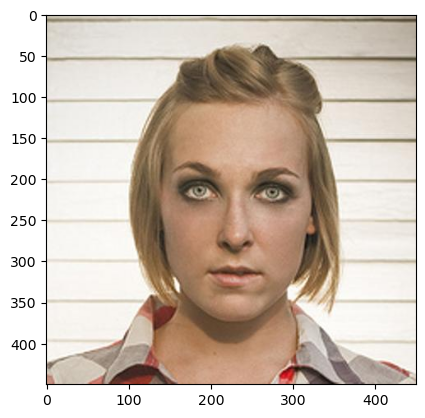

In [2]:
demo_image_num = 93
img_path = glob.glob('AFLW2000/*.jpg')
print(len(img_path))

img = cv2.imread(img_path[demo_image_num])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('이미지 크기: ', img.shape)

plt.figure()
plt.imshow(img);

Mat 파일은 이미지의 정보를 담고 있으며, "Pose_Para"는 이미지의 Roll, Pitch, Yaw정보를 담고 있다.

In [3]:
img_mat_paths = glob.glob('./AFLW2000/*.mat')
mat = scipy.io.loadmat(img_mat_paths[demo_image_num])
mat['Pose_Para'][0][:3]

array([-0.09699955, -0.43404898, -0.04423527], dtype=float32)

## Mediapipe로 코의 위치를 한번 찾아보자. 

nose position:  (229.51576709747314, 278.14797163009644)


I0000 00:00:1719823525.134560   15212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719823525.154356   15371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA GeForce RTX 3080 Ti/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1719823525.156599   15358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719823525.161398   15356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/mosi/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Plea

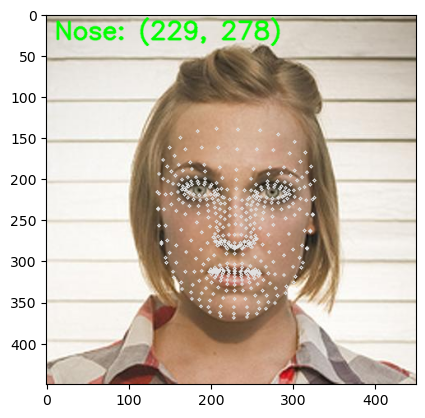

In [4]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
drawing_specs = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)
results = face_mesh.process(img)

img_h, img_w, img_c = img.shape
img_copy = img.copy()

# 아무 얼굴도 감지되지 않은 경우
if results.multi_face_landmarks == None:
    print('No face detected')
else:
    # 얼굴 랜드마크를 이미지 위에 그리기
    for face_landmarks in results.multi_face_landmarks:        
        mp.solutions.drawing_utils.draw_landmarks(image=img_copy, landmark_list=face_landmarks, landmark_drawing_spec=drawing_specs)
        for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
            if idx == 1:
                nose_x = lm.x * img_w
                nose_y = lm.y * img_h


text = "Nose: ({}, {})".format(int(nose_x), int(nose_y))
cv2.putText(img_copy, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


print('nose position: ', (nose_x, nose_y))
plt.figure()
plt.imshow(img_copy);

### 코 위치에 좌표계를 띄워보자.

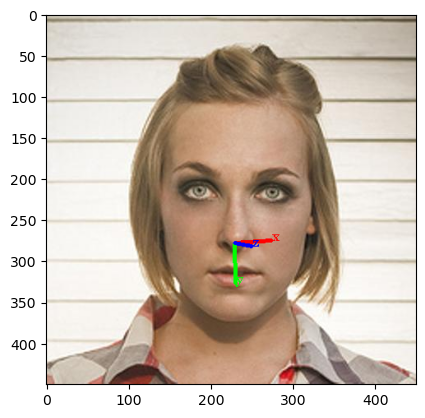

In [5]:
def draw_axes(img, pitch, yaw, roll, tx, ty, size=50):
    yaw = -yaw
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)
    axes_points = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]
    ], dtype=np.float64)
    axes_points = rotation_matrix @ axes_points
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty
    
    new_img = img.copy()
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 0].ravel()), (255, 0, 0), 3)
    cv2.putText(new_img, 'x', tuple(axes_points[:, 0].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 0), 1)
    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 1].ravel()), (0, 255, 0), 3)
    cv2.putText(new_img, 'y', tuple(axes_points[:, 1].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 0), 1)
    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 2].ravel()), (0, 0, 255), 3)
    cv2.putText(new_img, 'z', tuple(axes_points[:, 2].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1)

    return new_img

pitch, yaw, roll = mat['Pose_Para'][0][:3]
img_copy = draw_axes(img, pitch, yaw, roll, nose_x, nose_y)
plt.figure()

plt.imshow(img_copy);

### 각 얼굴의 특징점을 찾아내보자.

In [6]:
def extract_features(img, face_mesh, mat=None):
    NOSE = 1
    FOREHEAD = 10
    LEFT_EYE = 33
    MOUTH_LEFT = 61
    CHIN = 199
    RIGHT_EYE = 263
    MOUTH_RIGHT = 291


    result = face_mesh.process(img)
    face_features = []

    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                    face_features.append(lm.x)
                    face_features.append(lm.y)
    else:
        face_features.extend([None] * 14)
    
    if mat:
        pose_angles = mat['Pose_Para'][0][:3]
        face_features.extend(pose_angles)
        
    return face_features
    
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
s = extract_features(img, face_mesh)
img_copy = img.copy()

for i in range(len(s)//2):
        cv2.circle(img_copy, center=[int(s[i*2]*img_w), int(s[i*2+1]*img_h)], radius=4, color=(255, 0, 0), thickness=-1)
plt.figure()
plt.imshow(img_copy);

I0000 00:00:1719823741.458778   15212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719823741.471084   15628 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA GeForce RTX 3080 Ti/PCIe/SSE2
W0000 00:00:1719823741.472775   15616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719823741.477282   15617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


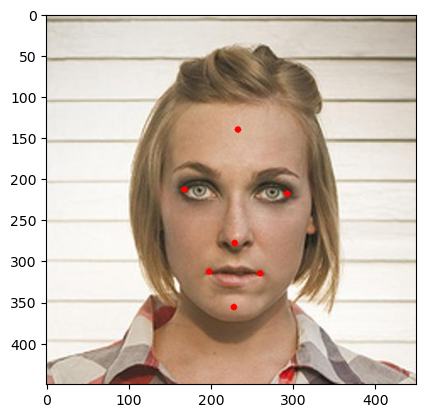

### 모든 이미지의 코, 이마, 눈, 입, 턱의 위치를 Mediapipe로 찾아낸 뒤, DataFrame으로 저장하자.

In [8]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)
cols.extend(['pitch', 'yaw', 'roll'])

In [9]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
poses = []

for img_idx, path in enumerate(img_path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mat = scipy.io.loadmat(img_mat_paths[img_idx])
    face_features = extract_features(img, face_mesh, mat)
    poses.append(face_features)
    if img_idx % 100 == 0:
        print('이미지 처리 중: ', img_idx)

poses_df = pd.DataFrame(poses, columns=cols)

I0000 00:00:1719823750.453177   15212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719823750.468958   15687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA GeForce RTX 3080 Ti/PCIe/SSE2
W0000 00:00:1719823750.470354   15673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719823750.474922   15686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


이미지 처리 중:  0
이미지 처리 중:  100
이미지 처리 중:  200
이미지 처리 중:  300
이미지 처리 중:  400
이미지 처리 중:  500
이미지 처리 중:  600
이미지 처리 중:  700
이미지 처리 중:  800
이미지 처리 중:  900
이미지 처리 중:  1000
이미지 처리 중:  1100
이미지 처리 중:  1200
이미지 처리 중:  1300
이미지 처리 중:  1400
이미지 처리 중:  1500
이미지 처리 중:  1600
이미지 처리 중:  1700
이미지 처리 중:  1800
이미지 처리 중:  1900


In [10]:
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.451679,0.609055,0.404365,0.410979,0.381974,0.574095,0.468733,0.706120,0.544774,0.754060,0.569314,0.460269,0.576348,0.649325,0.126109,-0.446191,-0.083462
1,0.439422,0.607954,0.486490,0.338330,0.405559,0.521101,0.423646,0.694512,0.464196,0.799527,0.615127,0.472582,0.544220,0.685053,-1.435948,1.364184,-1.519977
2,0.485300,0.600239,0.469743,0.336376,0.360095,0.509723,0.443119,0.710691,0.515569,0.798128,0.624627,0.471499,0.574513,0.694602,0.576966,1.280776,0.560692
3,0.501091,0.611103,0.473781,0.336079,0.359266,0.503002,0.451923,0.690303,0.536802,0.775016,0.643430,0.470050,0.605342,0.673914,0.126067,0.060540,-0.026330
4,0.482846,0.637960,0.420378,0.385910,0.386017,0.532038,0.492105,0.689028,0.566078,0.755922,0.596119,0.477614,0.609508,0.656046,0.064497,0.998015,0.062480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.439914,0.551226,0.549322,0.364449,0.445776,0.500111,0.402231,0.648553,0.411257,0.735277,0.614122,0.513562,0.491044,0.672593,-0.045438,1.197566,0.031494
1996,0.516104,0.615866,0.522741,0.333465,0.368000,0.475330,0.420328,0.689264,0.506111,0.795948,0.657319,0.495724,0.599257,0.694011,-0.029111,-0.380431,-0.011667
1997,0.495734,0.600421,0.478777,0.334405,0.355086,0.500622,0.432373,0.711180,0.516305,0.805851,0.641225,0.481056,0.583070,0.699904,0.004465,0.019403,0.036332
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.265435,0.365659,-0.025699


In [11]:
poses_df.to_csv('./poses.csv', index=False)

## 이제 얻은 데이터로 훈련을 시작해보자.

In [12]:
!pip3 install numpy pandas scikit-learn  matplotlib 

Defaulting to user installation because normal site-packages is not writeable


In [20]:
# 데이터 로드 및 결측값 제거
import pandas as pd
poses_df = pd.read_csv('./poses.csv')
poses_df = poses_df.dropna(axis=0)
poses_df.shape
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.534162,0.623934,0.518754,0.312075,0.349057,0.485040,0.424038,0.697132,0.499427,0.788211,0.635844,0.481809,0.570497,0.690742,-0.306358,-0.283822,0.038554
1992,0.569275,0.632902,0.562170,0.318961,0.386851,0.474827,0.442935,0.697338,0.522094,0.801679,0.665542,0.476053,0.592680,0.695240,-0.367547,-0.429723,0.122791
1994,0.604407,0.627700,0.664646,0.387628,0.503506,0.485360,0.507515,0.689498,0.547061,0.793431,0.736257,0.551269,0.645251,0.724783,-0.156035,0.567114,-0.108536
1995,0.486602,0.624109,0.522991,0.301004,0.354324,0.441646,0.412282,0.681156,0.483026,0.786989,0.680817,0.491351,0.567541,0.702234,-0.197102,-0.070430,0.105118


In [22]:
def normalize(poses_df):
    normalized_df = poses_df.copy()
    
    for dim in ['x', 'y']:
        # 중심화
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]
        
        
        # 스케일링
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff
    
    return normalized_df

poses_df = normalize(poses_df)
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.0,0.0,0.145389,-1.315685,-0.612647,-0.757945,-0.389327,0.157636,-0.035876,0.643461,0.821789,-0.634208,0.387353,0.242055,-0.399231,0.018227,0.085676
1,0.0,0.0,0.643168,-1.238742,0.061645,-0.584067,0.174874,0.306017,0.400586,0.764764,1.780222,-0.463914,1.061645,0.415933,0.470065,1.189533,0.300959
2,0.0,0.0,-0.012524,-1.450241,-0.134608,-0.661405,0.217967,0.362334,0.524888,0.861074,0.886842,-0.706921,0.865392,0.338595,-0.184650,0.881137,-0.236852
3,0.0,0.0,-0.239980,-1.951528,-0.454436,-0.874364,-0.017618,0.357641,0.334972,0.924901,0.547998,-1.273491,0.545564,0.125636,-0.175379,0.299208,-0.373374
4,0.0,0.0,0.206458,-1.236728,0.227247,-0.580952,0.552568,0.414430,0.860054,0.827818,1.380055,-0.666052,1.227247,0.419048,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.0,0.0,-0.069582,-1.516075,-0.835918,-0.675221,-0.497313,0.355848,-0.156862,0.798616,0.459186,-0.690928,0.164082,0.324779,-0.306358,-0.283822,0.038554
1992,0.0,0.0,-0.034515,-1.424327,-0.886287,-0.717177,-0.613809,0.292342,-0.229223,0.765727,0.467706,-0.711614,0.113713,0.282823,-0.367547,-0.429723,0.122791
1994,0.0,0.0,0.424978,-1.002710,-0.711851,-0.594513,-0.683567,0.258108,-0.404571,0.692207,0.930189,-0.319230,0.288149,0.405487,-0.156035,0.567114,-0.108536
1995,0.0,0.0,0.170664,-1.239908,-0.620394,-0.700198,-0.348568,0.218915,-0.016775,0.625044,0.910883,-0.509458,0.379606,0.299802,-0.197102,-0.070430,0.105118


In [23]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(poses_df, test_size=0.2, random_state=42)


X_train = train_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_train = train_df[['pitch', 'yaw', 'roll']]

X_val = val_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_val = val_df[['pitch', 'yaw', 'roll']]
print(X_train.shape, y_train.shape)

(1433, 14) (1433, 3)


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import scipy.stats

param_grid = {
    'estimator__kernel': ['rbf'],
    'estimator__C': np.arange(0.6, 0.75, 0.01),
    'estimator__gamma': np.arange(0.09, 0.1, 0.001),
    'estimator__epsilon': np.arange(0.07, 0.08, 0.001)
}

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
grid_search = GridSearchCV(multi_out_svr, param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
print('best parameters: ', grid_search.best_params_)
print('train_rmse: ', np.sqrt(-grid_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, model.predict(X_val))))

best parameters:  {'estimator__C': 0.7500000000000001, 'estimator__epsilon': 0.07900000000000001, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}
train_rmse:  0.22763984301415535
validation_rmse:  0.18924742614596662


In [18]:
pickle.dump(model, open('./best_model.pkl', 'wb'))